## Importing Modules and Reading Data

In [42]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import pickle

In [43]:
%matplotlib inline

In [67]:
data_location = 'sqlite:///../../data/data.db'

In [68]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)

In [69]:
ohlc.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC


In [70]:
ohlc.describe()

,open,high,low,close,volume,volumeUSD
count,11627.000000,11627.000000,11627.000000,11627.000000,1.162700e+04,1.162700e+04
mean,5708.198992,5737.512791,5676.641523,5706.967946,7.782893e+05,9.847622e+06
std,16518.161143,16599.532113,16430.972527,16514.731530,2.057505e+06,1.769057e+07
min,0.999900,1.000000,0.995100,0.999900,6.713000e+00,1.960784e+03
25%,4.555900,4.611000,4.496050,4.554350,2.565695e+03,9.664755e+05
50%,92.590000,93.710000,91.000000,92.600000,4.624230e+04,3.420994e+06
75%,307.924500,309.700000,305.501000,307.796500,1.768436e+05,1.068309e+07
max,68638.470000,69000.000000,68456.500000,68639.630000,3.978895e+07,3.988035e+08


## Feature Engineering and Exploration

In [71]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [72]:
df = ohlc.assign(ts=pd.to_datetime(ohlc['ts'])).set_index('ts')

In [83]:
tokens = ohlc.token.unique()
df.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC


In [125]:
dfs = [
    (lambda x: (
        x
        .assign(vol=vol_ohlc(x), 
                ret=x.close.pct_change())
        [['vol', 'ret', 'volume', 'volumeUSD']]
        .rename(columns=lambda col: f'{col}_{token}')))(df[df['token'] == token])
    for token in tokens
    ]
X = pd.concat(dfs, axis=1)
X.head()

,vol_BTC,ret_BTC,volume_BTC,volumeUSD_BTC,vol_ETH,ret_ETH,volume_ETH,volumeUSD_ETH,vol_USDT,ret_USDT,...,volume_CRV,volumeUSD_CRV,vol_AAVE,ret_AAVE,volume_AAVE,volumeUSD_AAVE,vol_COMP,ret_COMP,volume_COMP,volumeUSD_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:00:00,NaN,NaN,256.433869,1.575751e+07,NaN,NaN,4406.453807,1.891843e+07,NaN,NaN,...,107439.71,4.737806e+05,NaN,NaN,467.302,146986.295322,NaN,NaN,2316.913,7.968014e+05
2021-11-01 01:00:00,NaN,0.004357,332.481185,2.044558e+07,NaN,0.006874,8189.769397,3.531458e+07,NaN,0.0000,...,249880.26,1.105660e+06,NaN,0.008043,2421.882,765684.562567,NaN,-0.002281,1366.804,4.718005e+05
2021-11-01 02:00:00,NaN,-0.004508,314.250720,1.935390e+07,NaN,-0.005322,4866.479502,2.098699e+07,NaN,-0.0002,...,373119.36,1.618417e+06,NaN,-0.009171,737.288,233474.679261,NaN,-0.006020,2771.400,9.616592e+05
2021-11-01 03:00:00,NaN,-0.012132,1059.931358,6.414625e+07,NaN,-0.013126,13426.940129,5.695059e+07,NaN,0.0001,...,706529.59,2.994307e+06,NaN,-0.013301,2382.998,739999.141805,NaN,-0.022273,3615.275,1.220542e+06
2021-11-01 04:00:00,NaN,-0.010186,621.419878,3.744744e+07,NaN,-0.010679,8460.070019,3.567936e+07,NaN,0.0000,...,250157.22,1.069410e+06,NaN,-0.016452,1653.940,510601.584936,NaN,-0.024002,2391.802,7.975887e+05


In [126]:
X.shape

(1057, 44)

In [127]:
X = X.dropna(axis=0, how='any')
X.shape

(1047, 44)

In [128]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]

In [138]:
X.describe()

,vol_BTC,ret_BTC,volume_BTC,volumeUSD_BTC,vol_ETH,ret_ETH,volume_ETH,volumeUSD_ETH,vol_USDT,ret_USDT,...,volume_CRV,volumeUSD_CRV,vol_AAVE,ret_AAVE,volume_AAVE,volumeUSD_AAVE,vol_COMP,ret_COMP,volume_COMP,volumeUSD_COMP
count,1046.000000,1046.000000,1046.000000,1.046000e+03,1046.000000,1046.000000,1046.000000,1.046000e+03,1046.000000,1.046000e+03,...,1.046000e+03,1.046000e+03,1046.000000,1046.000000,1046.000000,1.046000e+03,1046.000000,1046.000000,1046.000000,1.046000e+03
mean,0.124096,-0.000214,619.735866,3.499009e+07,0.142427,-0.000079,8093.483039,3.486609e+07,0.007992,1.982155e-08,...,2.511283e+05,1.107447e+06,0.173098,-0.000546,2129.269122,5.371156e+05,0.194581,-0.000540,1139.830005,3.305503e+05
std,0.077673,0.006927,512.019959,2.744209e+07,0.065377,0.008012,7063.479359,2.918880e+07,0.014617,1.992994e-04,...,2.281894e+05,1.107238e+06,0.095970,0.010009,1845.313895,4.613362e+05,0.096643,0.011349,1104.143194,3.439934e+05
min,0.051984,-0.049853,8.831810,5.085925e+05,0.060152,-0.055916,46.691083,2.027631e+05,0.001575,-1.893185e-03,...,3.937920e+03,1.991889e+04,0.066556,-0.068892,45.806000,1.236127e+04,0.072980,-0.064433,6.713000,1.960784e+03
25%,0.087228,-0.003880,313.888556,1.788243e+07,0.102649,-0.004259,3869.757902,1.679061e+07,0.002393,-9.991008e-05,...,1.007046e+05,4.112206e+05,0.117870,-0.005669,971.627500,2.550078e+05,0.136282,-0.006596,538.638250,1.482839e+05
50%,0.105694,-0.000300,495.267527,2.792859e+07,0.126302,-0.000081,6299.060791,2.758206e+07,0.003302,0.000000e+00,...,1.777866e+05,7.376127e+05,0.153923,-0.000186,1672.275000,4.298583e+05,0.170767,0.000050,849.446500,2.494204e+05
75%,0.139860,0.003353,773.409796,4.442073e+07,0.165315,0.004337,9813.951164,4.237420e+07,0.004951,9.992006e-05,...,3.243045e+05,1.397753e+06,0.205140,0.005296,2749.308750,6.740891e+05,0.225524,0.005793,1336.550250,3.821849e+05
max,0.795166,0.034570,8420.715164,3.988035e+08,0.578180,0.030893,97097.417492,3.702769e+08,0.113821,4.194966e-03,...,1.901496e+06,9.613040e+06,0.925958,0.043170,19671.730000,4.924009e+06,0.779508,0.049172,11253.000000,3.890619e+06


In [142]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

In [140]:
def evaluate_model(model, X, y, test_size=.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0]*test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])

In [143]:
pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('model', Ridge())
    ]
)

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': [1, 5, 10, 20, 22],
    'model__alpha': [0.1, 0.5,  1.]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=209, test_size=1),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()), ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 0.5, 1.0],
                         'pca__n_components': [1, 5, 10, 20, 22]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [144]:
search.best_params_

{'model__alpha': 0.1, 'pca__n_components': 5}

In [145]:
best_model = search.best_estimator_

In [146]:
evaluate_model(best_model, X, y)

-0.00847776109080044

## Learning Curve

In [148]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

<module 'matplotlib.pyplot' from '/Users/tusharjain/opt/miniconda/envs/hw8/lib/python3.9/site-packages/matplotlib/pyplot.py'>

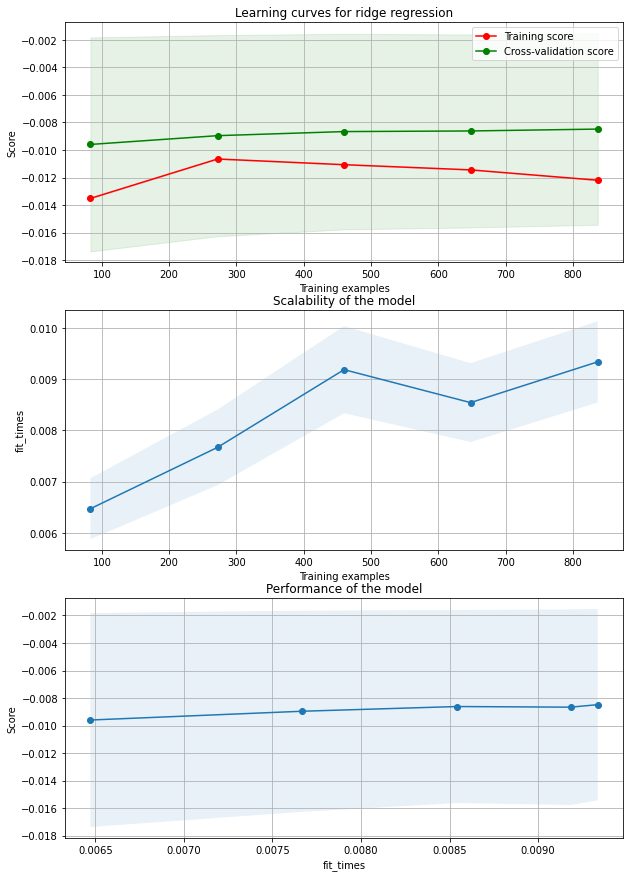

In [149]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for ridge regression"

plot_learning_curve(
    best_model, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)



## Final Score

In [150]:
evaluate_model(best_model, X, y)

-0.008477775869781778